In [ ]:
# Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
#!pip install japanize-matplotlib
#import japanize_matplotlib

In [ ]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())


torch: 2.9.0+cu126
cuda available: True


1. CSV 読み込み（教師ありデータ）
2. Tokenize（文字列 → 単語列）
3. Vocab 構築（単語 → ID）
4. 数値化 + Padding
5. LSTM による系列分類
6. Train と Valid 、 Test csvを使って評価

In [ ]:
path1 = "/content/drive/MyDrive/38_自然言語処理/映画レビュ/IMBD_Data/Train.csv"
path2 = "/content/drive/MyDrive/38_自然言語処理/映画レビュ/IMBD_Data/Test.csv"
path3 = "/content/drive/MyDrive/38_自然言語処理/映画レビュ/IMBD_Data/Valid.csv"

In [ ]:
# csv フアイル読み込み⇒DataFrameに変換

df1 = pd.read_csv(path1)   # Train
print("Train-行数:", len(df1))

df2 = pd.read_csv(path2) # Test
print("Test-行数:", len(df2))

df3 = pd.read_csv(path3) # Valid
print("Valid-行数:", len(df3))

df_all = pd.concat([df1, df2, df3])
print("全体-行数:", len(df_all))

Train-行数: 40000
Test-行数: 5000
Valid-行数: 5000
全体-行数: 50000


In [ ]:
# CSV（教師あり）→ 自前Vocab → LSTM

# 関数　tokenize()
import re
TOKEN_RE = re.compile(r"[A-Za-z']+")   # 記号・数字・いらない文字を削除
def tokenize(text: str):
    return TOKEN_RE.findall(text.lower())  # 全て小文字に変換

print(tokenize(df1.iloc[0]["text"])[:30])
display(df1.head())

['i', 'grew', 'up', 'b', 'watching', 'and', 'loving', 'the', 'thunderbirds', 'all', 'my', 'mates', 'at', 'school', 'watched', 'we', 'played', 'thunderbirds', 'before', 'school', 'during', 'lunch', 'and', 'after', 'school', 'we', 'all', 'wanted', 'to', 'be']


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
# レビューのサンプル　１行目(iloc[0])

display(df1["text"].iloc[0])

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'

In [ ]:
# 3) Vocab 構築

from collections import Counter

# 関数　tokenize()
import re

TOKEN_RE = re.compile(r"[A-Za-z']+")   # 英語の文字だけとりだす
def tokenize(text: str):
    return TOKEN_RE.findall(text.lower())


#  -----  build_vocab 辞書を作る　----------
PAD = "<pad>"     # パデイング
UNK = "<unk>"     # 未知の単語を置き換え

def build_vocab(texts, max_vocab=40000, max_len=300, min_freq=2):    # 2で除外
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))

    words = [w for w, c in counter.most_common(max_vocab) if c >= min_freq]
    itos = [PAD, UNK] + words
    stoi = {w:i for i, w in enumerate(itos)}
    return stoi, itos


stoi, itos = build_vocab(df1["text"])
pad_id = stoi[PAD]
unk_id = stoi[UNK]

# stoi 単語⇒数字に変換　対応表
# itos 数字⇒単語に変換　対応表
print("vocab size:", len(itos))
print(pad_id)
print(unk_id)

vocab size: 40002
0
1


In [ ]:
# 4) 数値化（文章 → ID列)

def encode(text, max_len=200):
    tokens = tokenize(text)
    ids = [stoi.get(t, unk_id) for t in tokens[:max_len]]
    return ids


In [ ]:
# 5) PyTorch Dataset,    DataFrameを変換する
# csv⇒DataFrame⇒　PyTorchに変換

import torch
from torch.utils.data import Dataset, DataLoader

class IMDB_Dataset(Dataset):
    def __init__(self, df, max_len=200):
        self.texts = df["text"].values
        self.labels = df["label"].values
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        ids = encode(self.texts[idx], self.max_len)
        return torch.tensor(ids), torch.tensor(self.labels[idx])


def collate_fn(batch):
    xs, ys = zip(*batch)
    lengths = torch.tensor([len(x) for x in xs])
    max_len = lengths.max().item()

    padded = torch.full((len(xs), max_len), pad_id)
    for i, x in enumerate(xs):
        padded[i, :len(x)] = x

    return padded.long(), lengths.long(), torch.tensor(ys).long()


In [ ]:
# DataFrameからPyTorchに入れられるように変換
# train_loader  valid_loader  test_loader ⇒　PyTorchへの入力

batch_size_val = 64  #バッチサイズ

train_loader = DataLoader(IMDB_Dataset(df1),
                          batch_size=batch_size_val, shuffle=True,
                          collate_fn=collate_fn)

valid_loader = DataLoader(IMDB_Dataset(df3),
                          batch_size=batch_size_val, shuffle=False,
                          collate_fn=collate_fn)

test_loader  = DataLoader(IMDB_Dataset(df2),
                          batch_size=batch_size_val, shuffle=False,
                          collate_fn=collate_fn)


In [ ]:
# 6) LSTM 感情分類モデル
# x は shape (B, T)
# embedding は ID をベクトルに変換, emb は shape (B, T, E) のベクトル列
# h_n[-1] は 最終層の最終隠れ状態で、shape (B, H)
# B：バッチサイズ　T：タイムステップ　H：内部の次元数

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

# ------------- LSTM_Sentiment  --------
class LSTM_Sentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
            )
        out, (h_n, _) = self.lstm(packed)
        return self.fc(h_n[-1])  # # 最終時刻の隠れ状態


In [ ]:
# 7) 学習・評価

#  --- 関数　run_epoch ----
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss, correct, total = 0, 0, 0
    step = 0
    for x, lengths, y in loader:   # x:ID列　lengths:文の長さ　y:正解ラベル
        step += 1
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        logits = model(x, lengths)
        loss = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        if step % 300 == 0:
            print("step={}  train loss{:.5f}".format(step, loss.item()))

        total_loss += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


In [ ]:
# main

# DataLoader ---
batch_size = 128
epochs = 7

train_losses = []
train_accs   = []
test_losses  = []
test_accs    = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTM_Sentiment(len(itos)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-03)

for epoch in range(1, epochs+1):
    train_loss, train_acc = run_epoch(train_loader, train=True)   # 学習

    valid_loss, valid_acc = run_epoch(valid_loader, train=False)   # 検証

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(valid_loss)
    test_accs.append(valid_acc)

    print(
        f"epoch {epoch} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"valid loss {valid_loss:.4f} acc {valid_acc:.4f}"
    )


step=300  train loss0.65637
step=600  train loss0.60707
epoch 1 | train loss 0.6433 acc 0.6236 | valid loss 0.6092 acc 0.6624
step=300  train loss0.49320
step=600  train loss0.60230
epoch 2 | train loss 0.5614 acc 0.7115 | valid loss 0.5917 acc 0.6742
step=300  train loss0.34026
step=600  train loss0.40083
epoch 3 | train loss 0.4375 acc 0.7940 | valid loss 0.3726 acc 0.8342
step=300  train loss0.30273
step=600  train loss0.23279
epoch 4 | train loss 0.2786 acc 0.8853 | valid loss 0.3559 acc 0.8506
step=300  train loss0.25381
step=600  train loss0.14064
epoch 5 | train loss 0.2078 acc 0.9195 | valid loss 0.3279 acc 0.8706
step=300  train loss0.10446
step=600  train loss0.09617
epoch 6 | train loss 0.1509 acc 0.9451 | valid loss 0.3417 acc 0.8674
step=300  train loss0.10123
step=600  train loss0.05580
epoch 7 | train loss 0.1031 acc 0.9639 | valid loss 0.4396 acc 0.8682


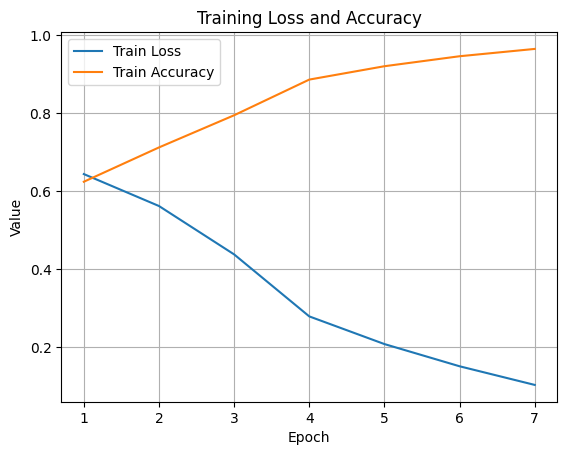

In [ ]:
# Train 用グラフ（Loss & Accuracy

import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure()
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Accuracy")
plt.legend()
plt.grid(True)
plt.show()


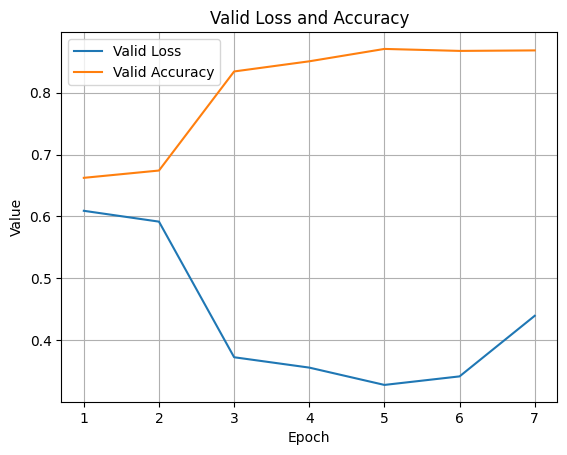

In [ ]:
# Test 用グラフ（Loss & Accuracy）

plt.figure()
plt.plot(epochs_range, test_losses, label="Valid Loss")
plt.plot(epochs_range, test_accs, label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Valid Loss and Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 混同行列

import torch

# 評価モード
model.eval()

# 正解ラベルと予測ラベルを保存
true_labels = []
pred_labels = []

with torch.no_grad():
    for x, lengths, y in test_loader:
        # GPUへ
        x = x.to(device)
        lengths = lengths.to(device)

        # モデルの出力
        logits = model(x, lengths)

        # 予測ラベル（0 or 1）
        preds = torch.argmax(logits, dim=1)  # im=0 → 縦方向（行方向）, dim=1 → 横方向（列方向）

        # CPU に戻して保存
        true_labels.extend(y.tolist())
        pred_labels.extend(preds.cpu().tolist())

# カウンタ初期化
TN = 0  # true 0, pred 0
FP = 0  # true 0, pred 1
FN = 0  # true 1, pred 0
TP = 0  # true 1, pred 1

# データ確認
for t, p in zip(true_labels, pred_labels):
    if t == 0 and p == 0:
        TN += 1
    elif t == 0 and p == 1:
        FP += 1
    elif t == 1 and p == 0:
        FN += 1
    elif t == 1 and p == 1:
        TP += 1

all_data = len(true_labels)
accuracy = (TP + TN) / all_data
print("評価結果⇒　0 = negative（否定的） 1 = positive（肯定的）")
print("データ数={}".format(all_data))
print("正解率={:.4f}".format(accuracy))

print("混同行列（行：真のラベル、列：予測ラベル）")
print("          予測0    予測1")
print(f"真0     {TN:6d}   {FP:6d}")
print(f"真1     {FN:6d}   {TP:6d}")

print()
print("誤りの内訳：")
print(f"0 → 1 の誤り（FP）: {FP}")
print(f"1 → 0 の誤り（FN）: {FN}")

# 0 と 1 でどちらの間違いが多いか。
if FP > FN:
    print("結論：ラベル0（negative）を1と誤判定する方が多い")
elif FN > FP:
    print("結論：ラベル1（positive）を0と誤判定する方が多い")
else:
    print("結論：誤り数は同程度")

評価結果⇒　0 = negative（否定的） 1 = positive（肯定的）
データ数=5000
正解率=0.8712
混同行列（行：真のラベル、列：予測ラベル）
          予測0    予測1
真0       2148      347
真1        297     2208

誤りの内訳：
0 → 1 の誤り（FP）: 347
1 → 0 の誤り（FN）: 297
結論：ラベル0（negative）を1と誤判定する方が多い
